# Start

In [1]:
import matplotlib as mpl
mpl.use('Agg')

In [2]:
%run max-profit.py

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'

mpl.rcParams['figure.dpi']= 300


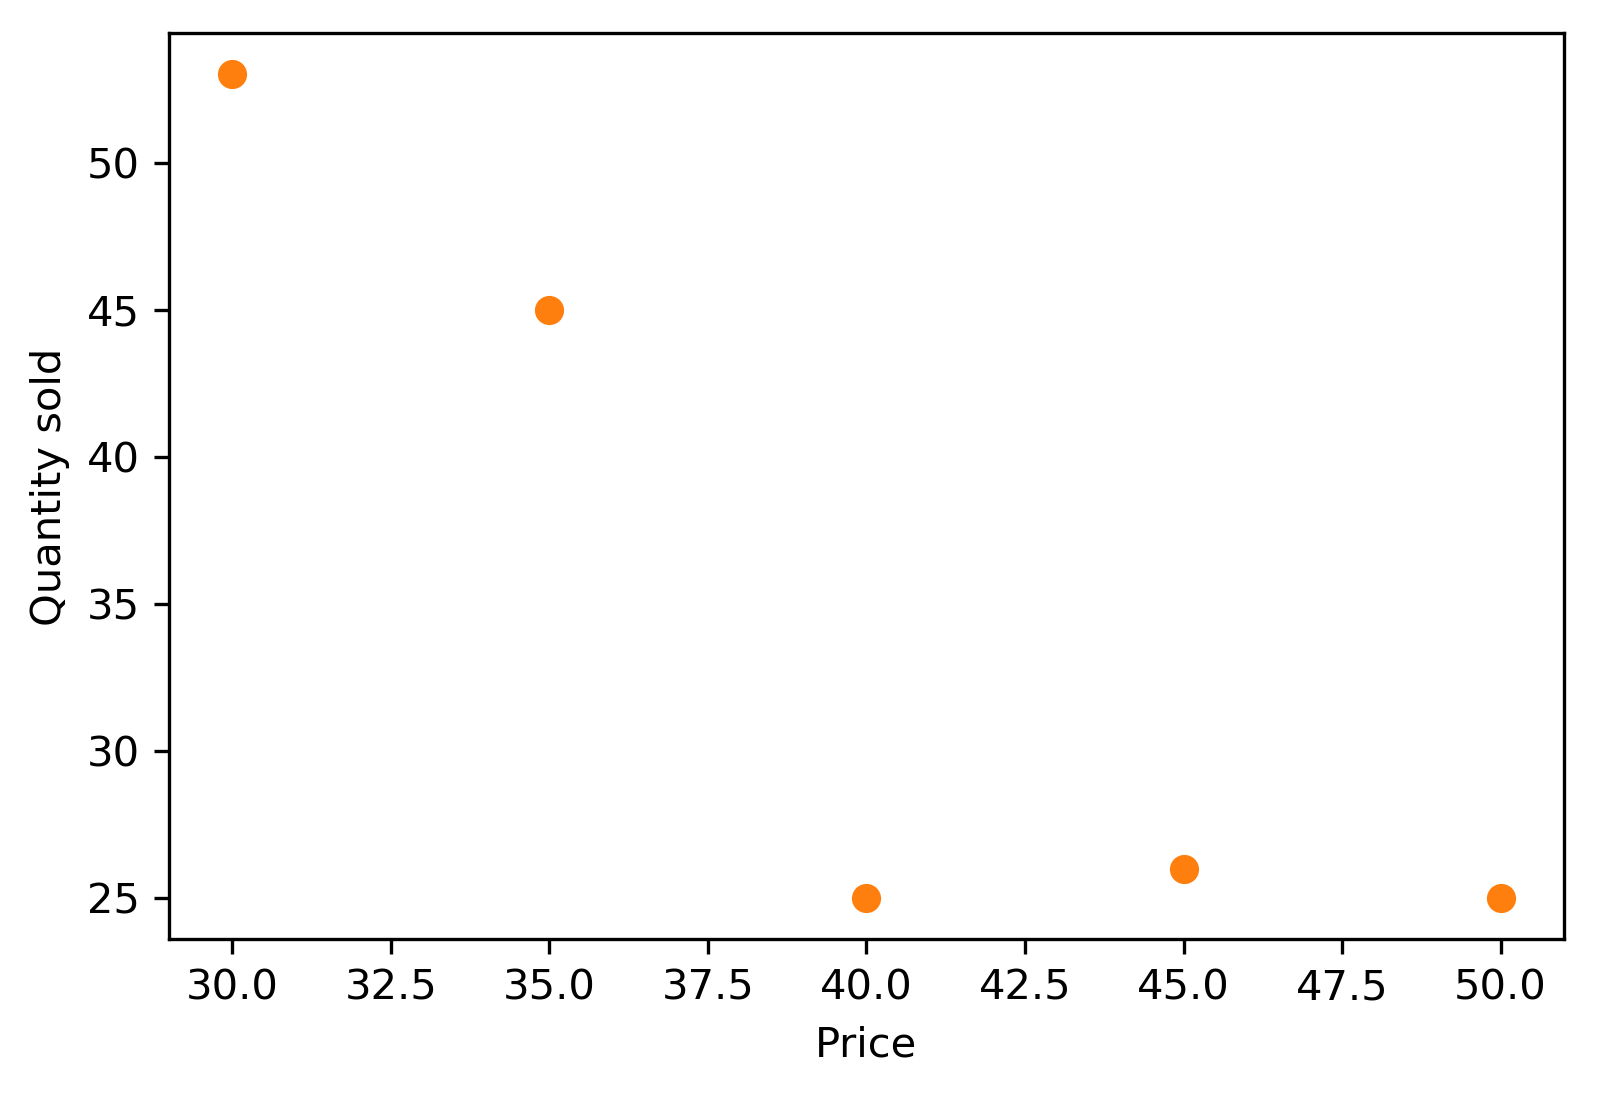

In [5]:
np.random.seed(42)
a = 50000
k = 20
c = -2
p  = np.linspace(25,55)
p0 = np.linspace(30,50,5)
eq = a * p**c
q0 = np.random.poisson(a * p0**c)
π = eq * (p - k)

# np.log(prices-k) + np.log(a) + c*np.log(prices)

#plt.plot(p,π);
plt.plot(p0,q0,'o',c='C1');
plt.xlabel('Price')
plt.ylabel('Quantity sold')
savefig("q0")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, loga]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 918.04draws/s] 
The acceptance probability does not match the target. It is 0.8901163051414377, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


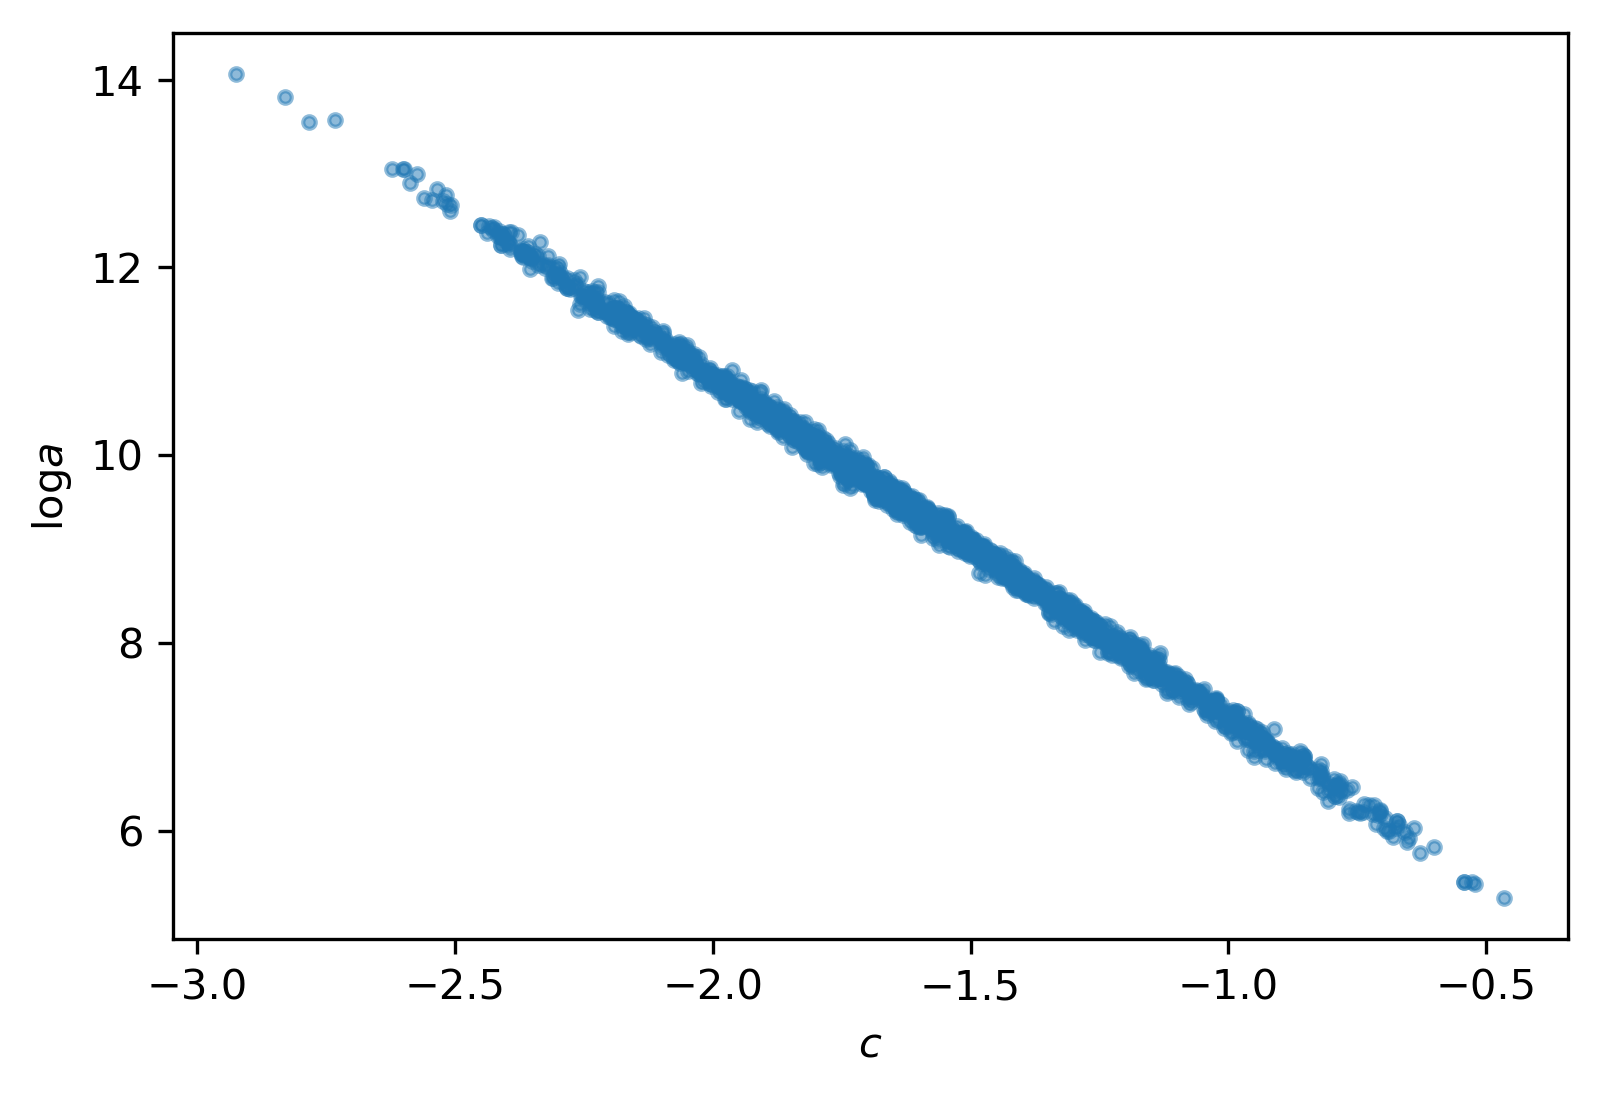

In [6]:
trace = fit0(p0,q0)
plt.plot(trace['c'],trace['loga'],'.',alpha=0.5)
plt.xlabel('$c$')
plt.ylabel('$\log a$')
savefig("uncentered")

In [7]:
t = fit(p0,q0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3766.48draws/s]
The acceptance probability does not match the target. It is 0.8811963903977847, but should be close to 0.8. Try to increase the number of tuning steps.


/home/chad/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


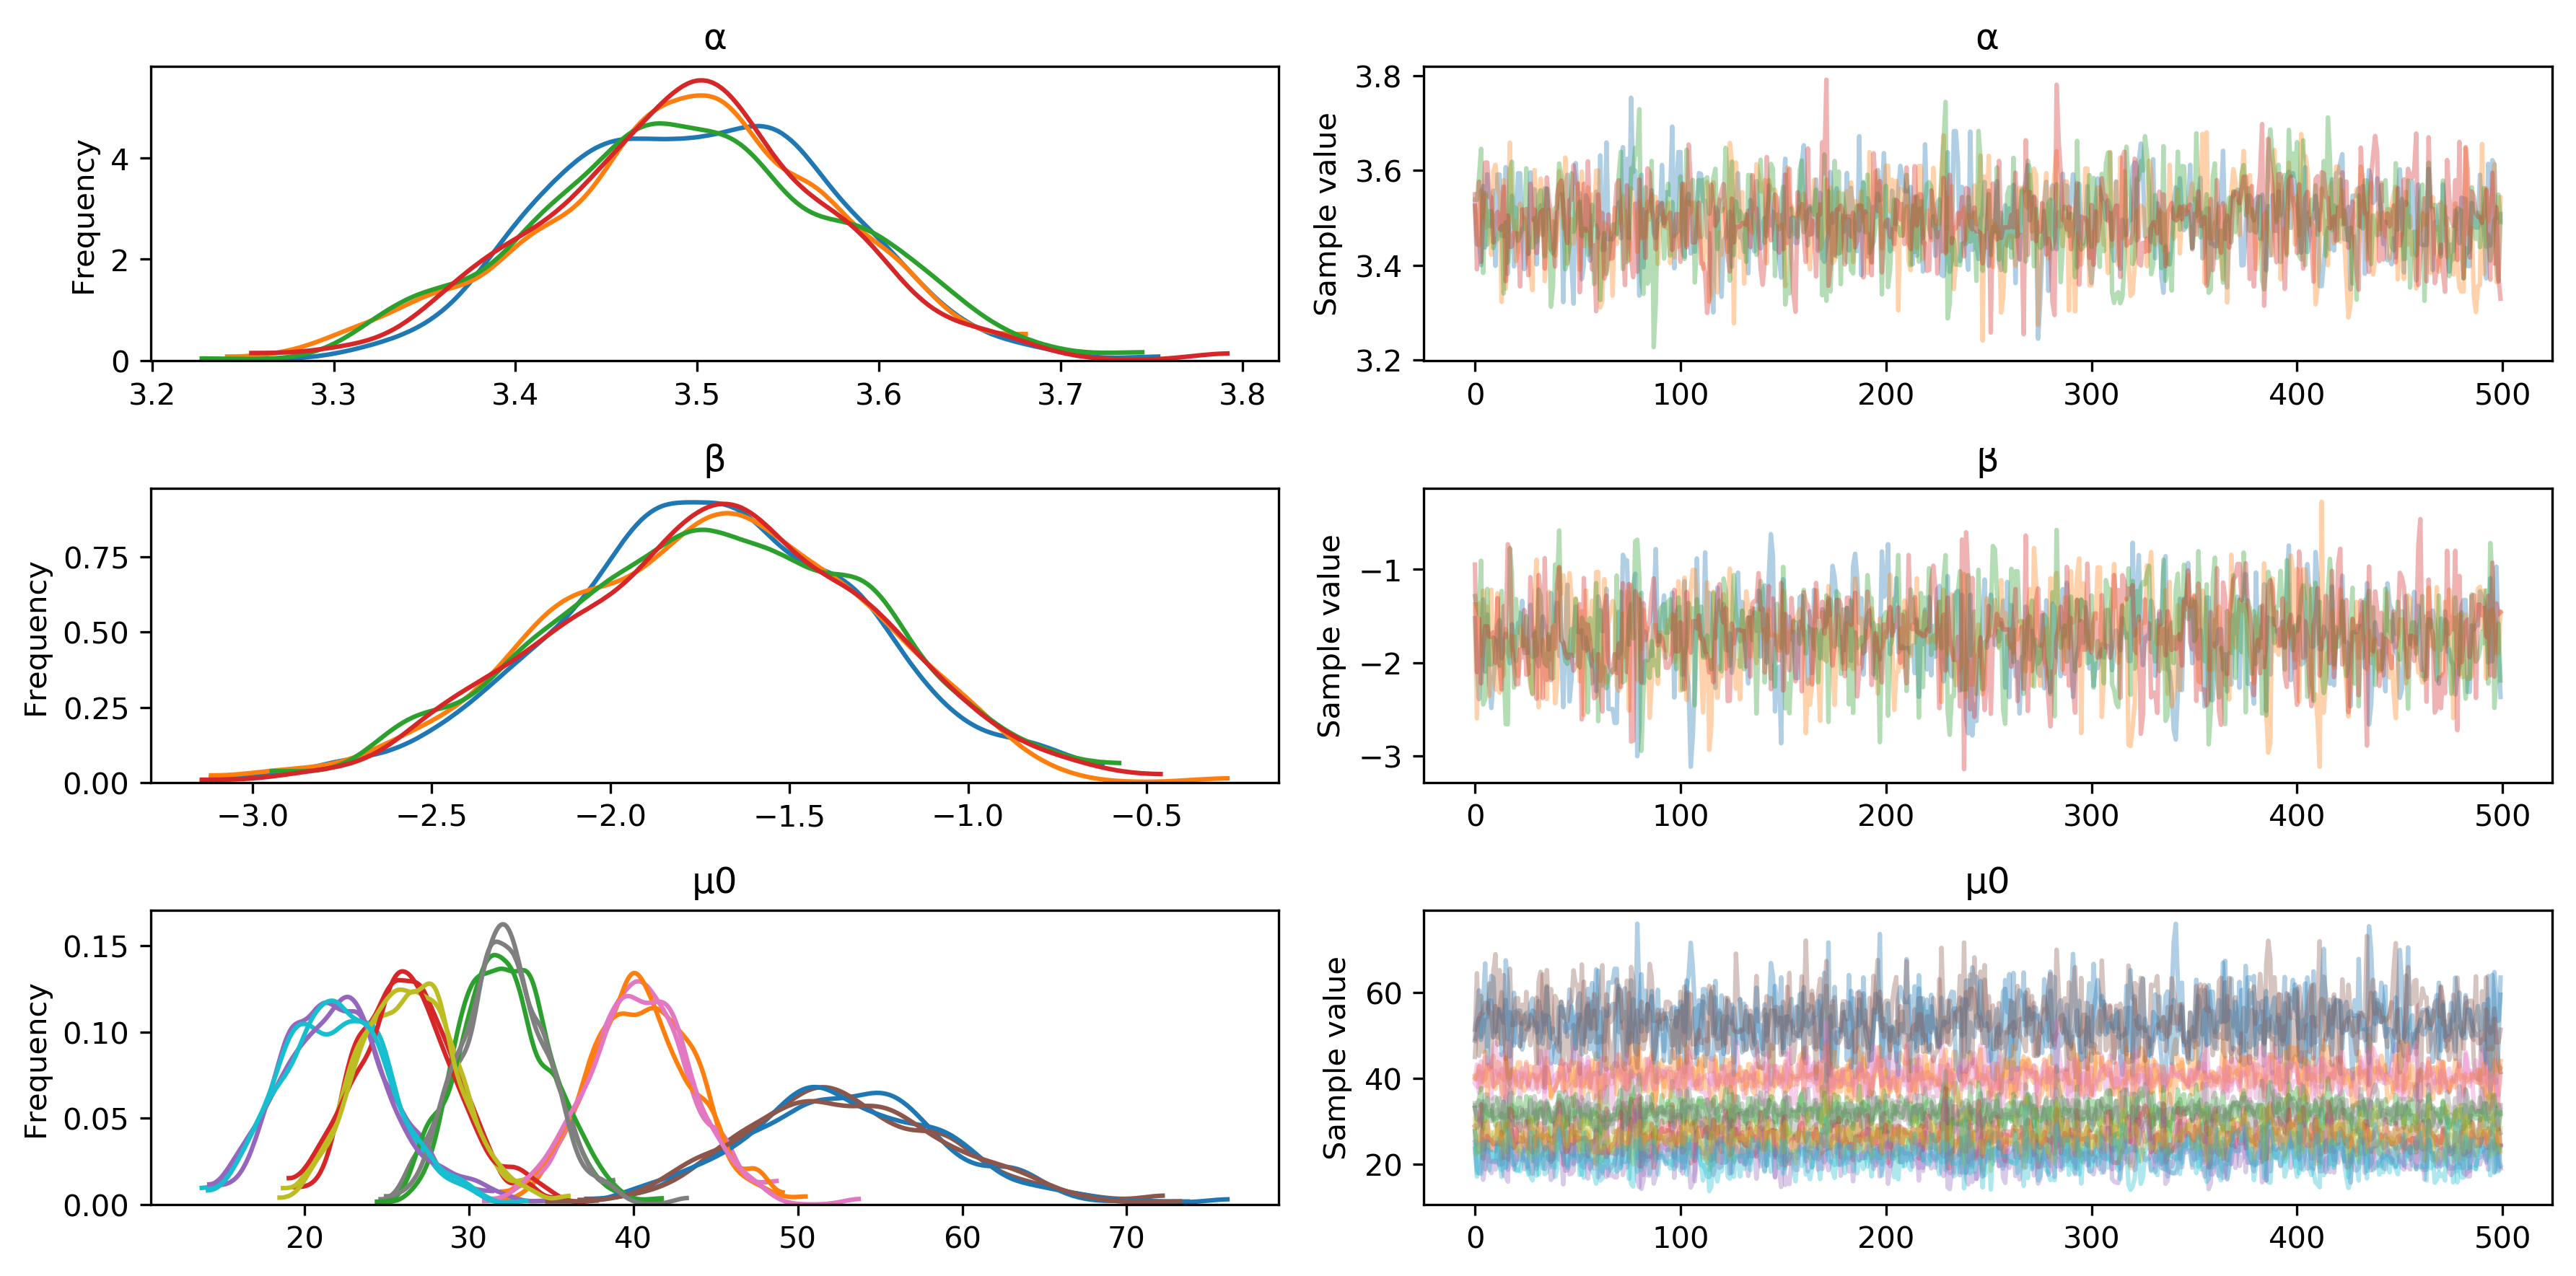

In [8]:
pm.traceplot(t);
savefig("traceplot")

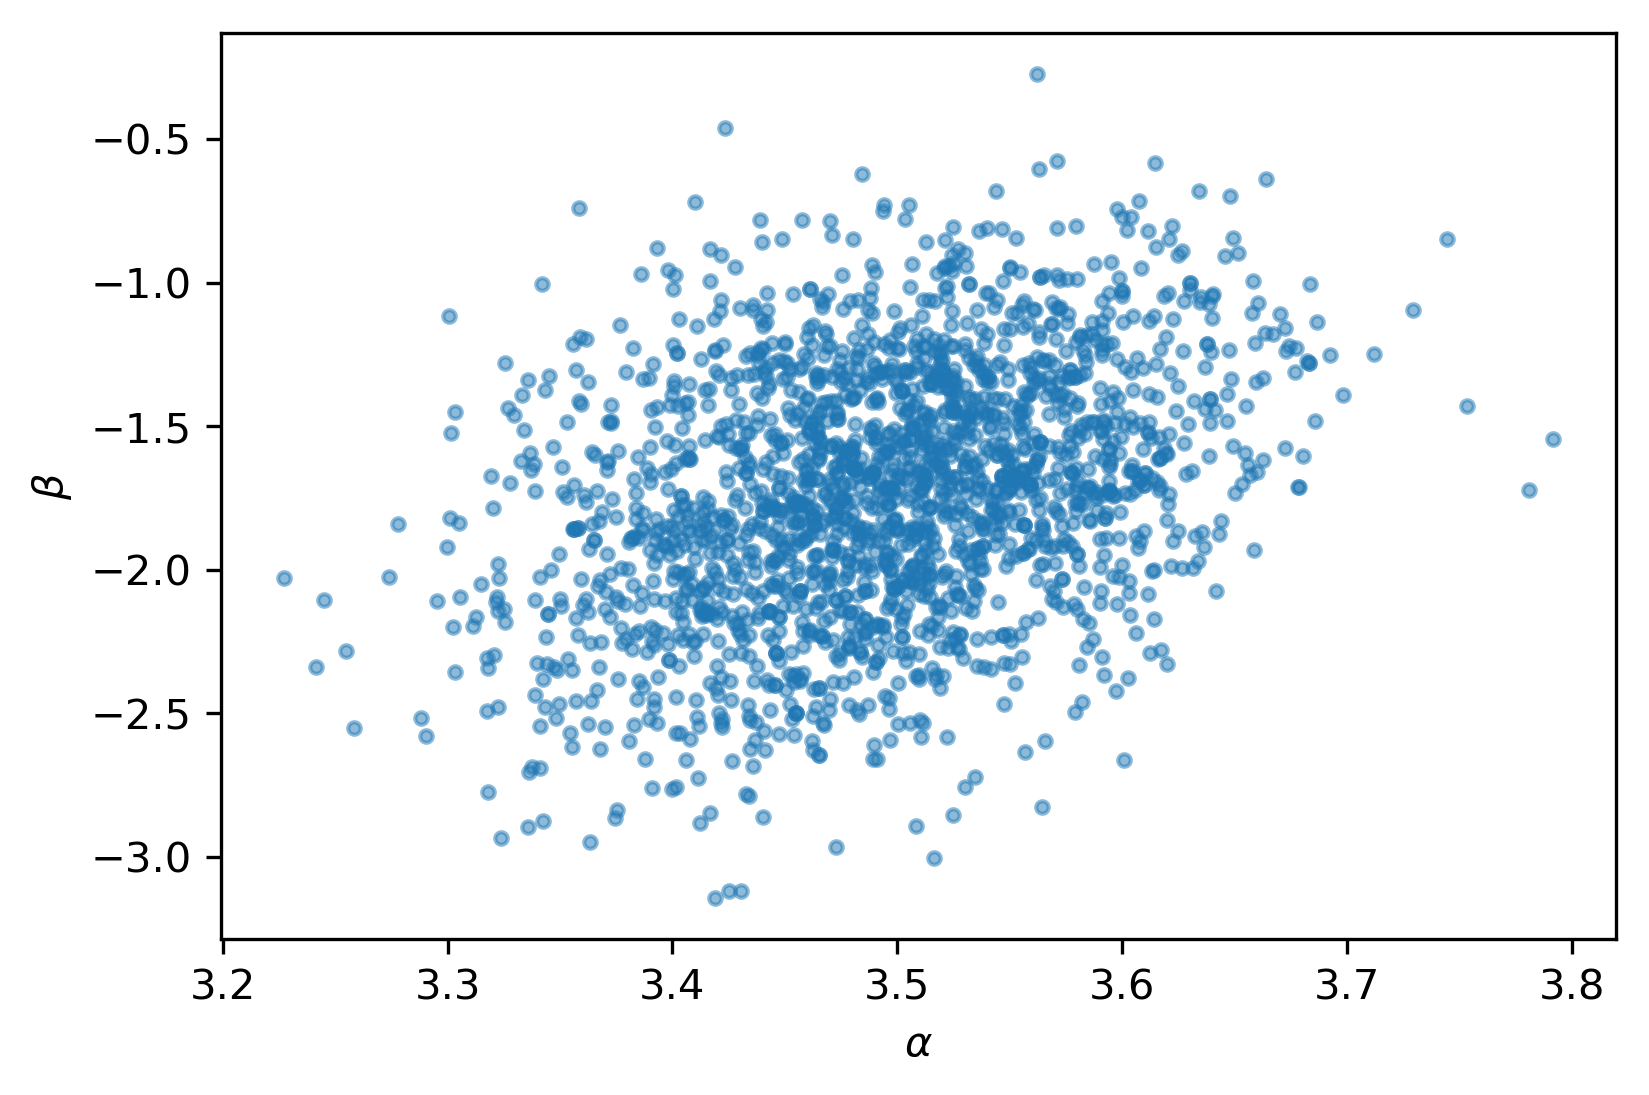

In [9]:
plt.plot(t['α'],t['β'],'.',alpha=0.5);
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
savefig('centered')

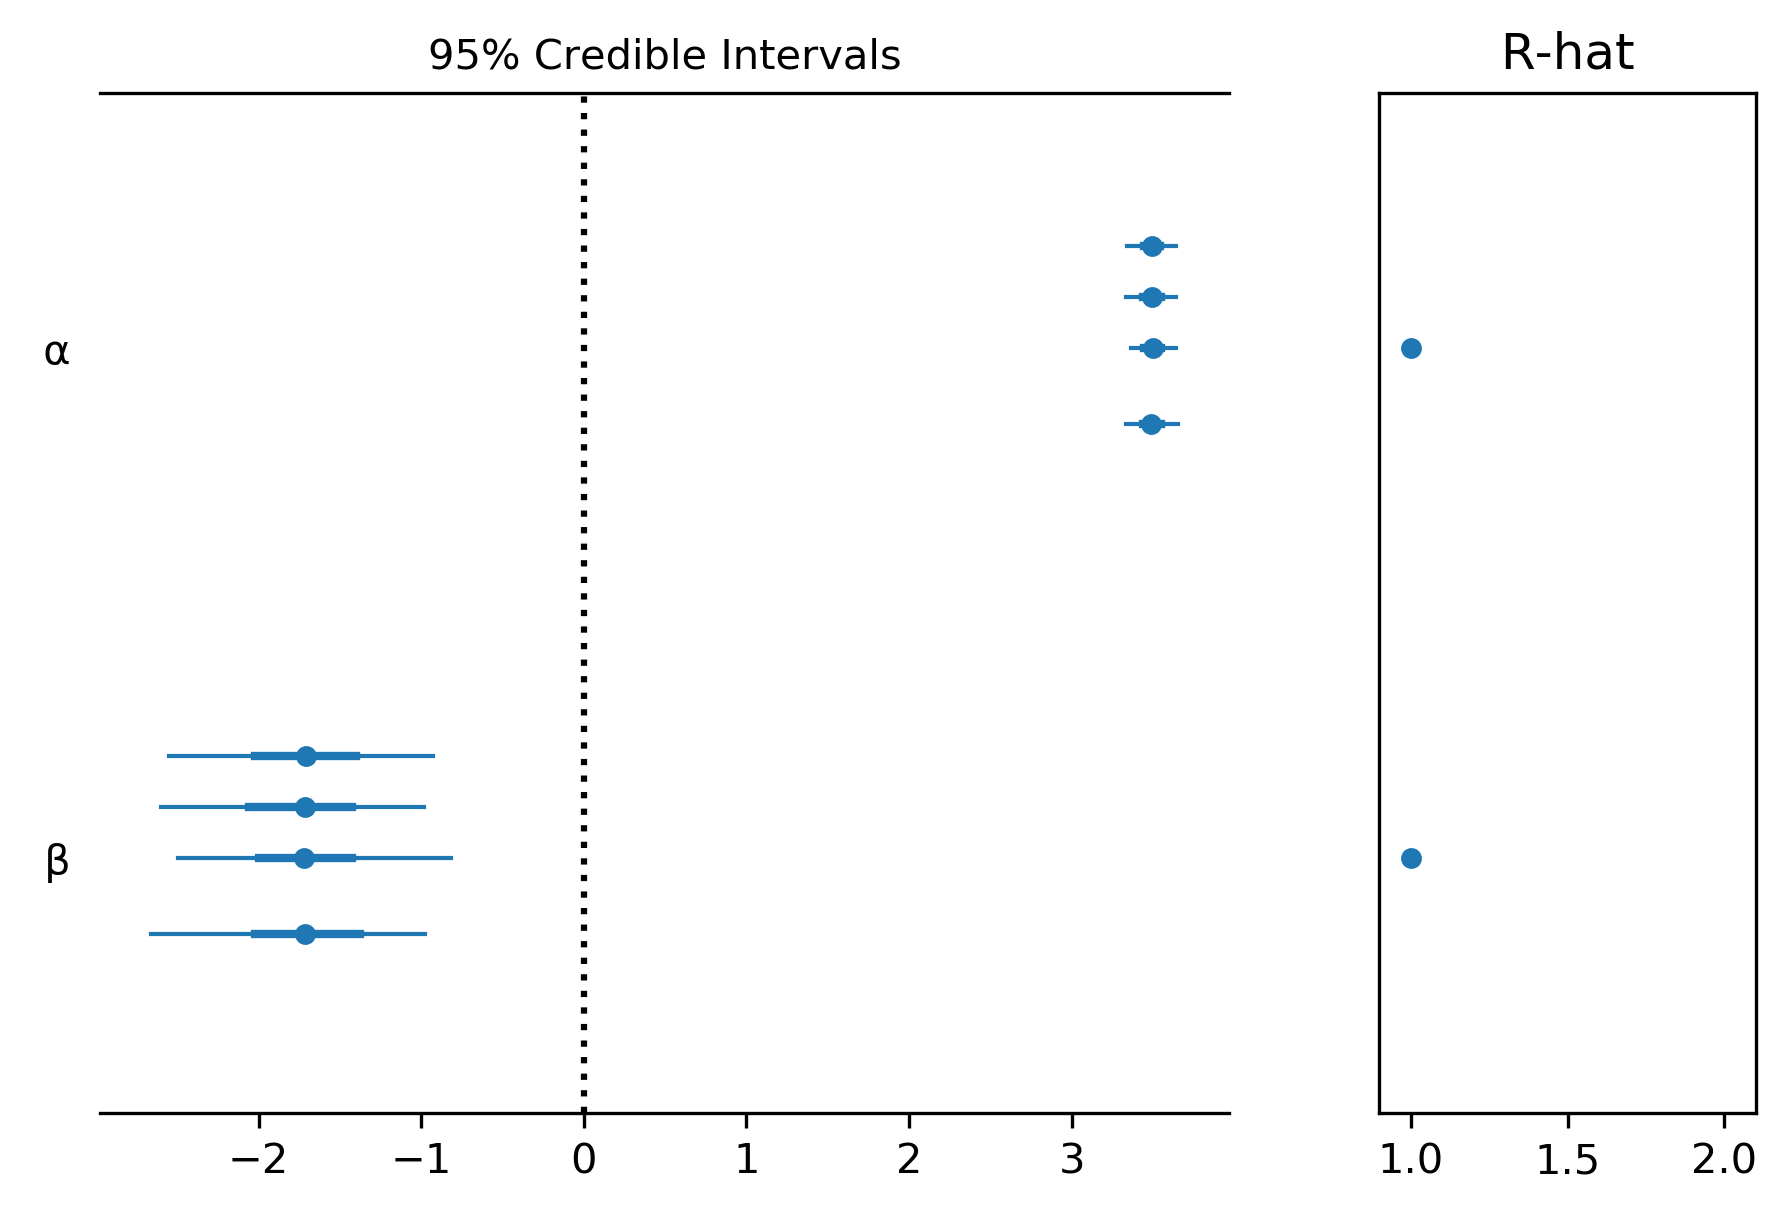

In [10]:
pm.forestplot(t,varnames=['α','β'])
savefig('forestplot')

In [11]:
μ = np.exp(t.α + t.β * (np.log(p).reshape(-1,1) - np.log(p0).mean()))

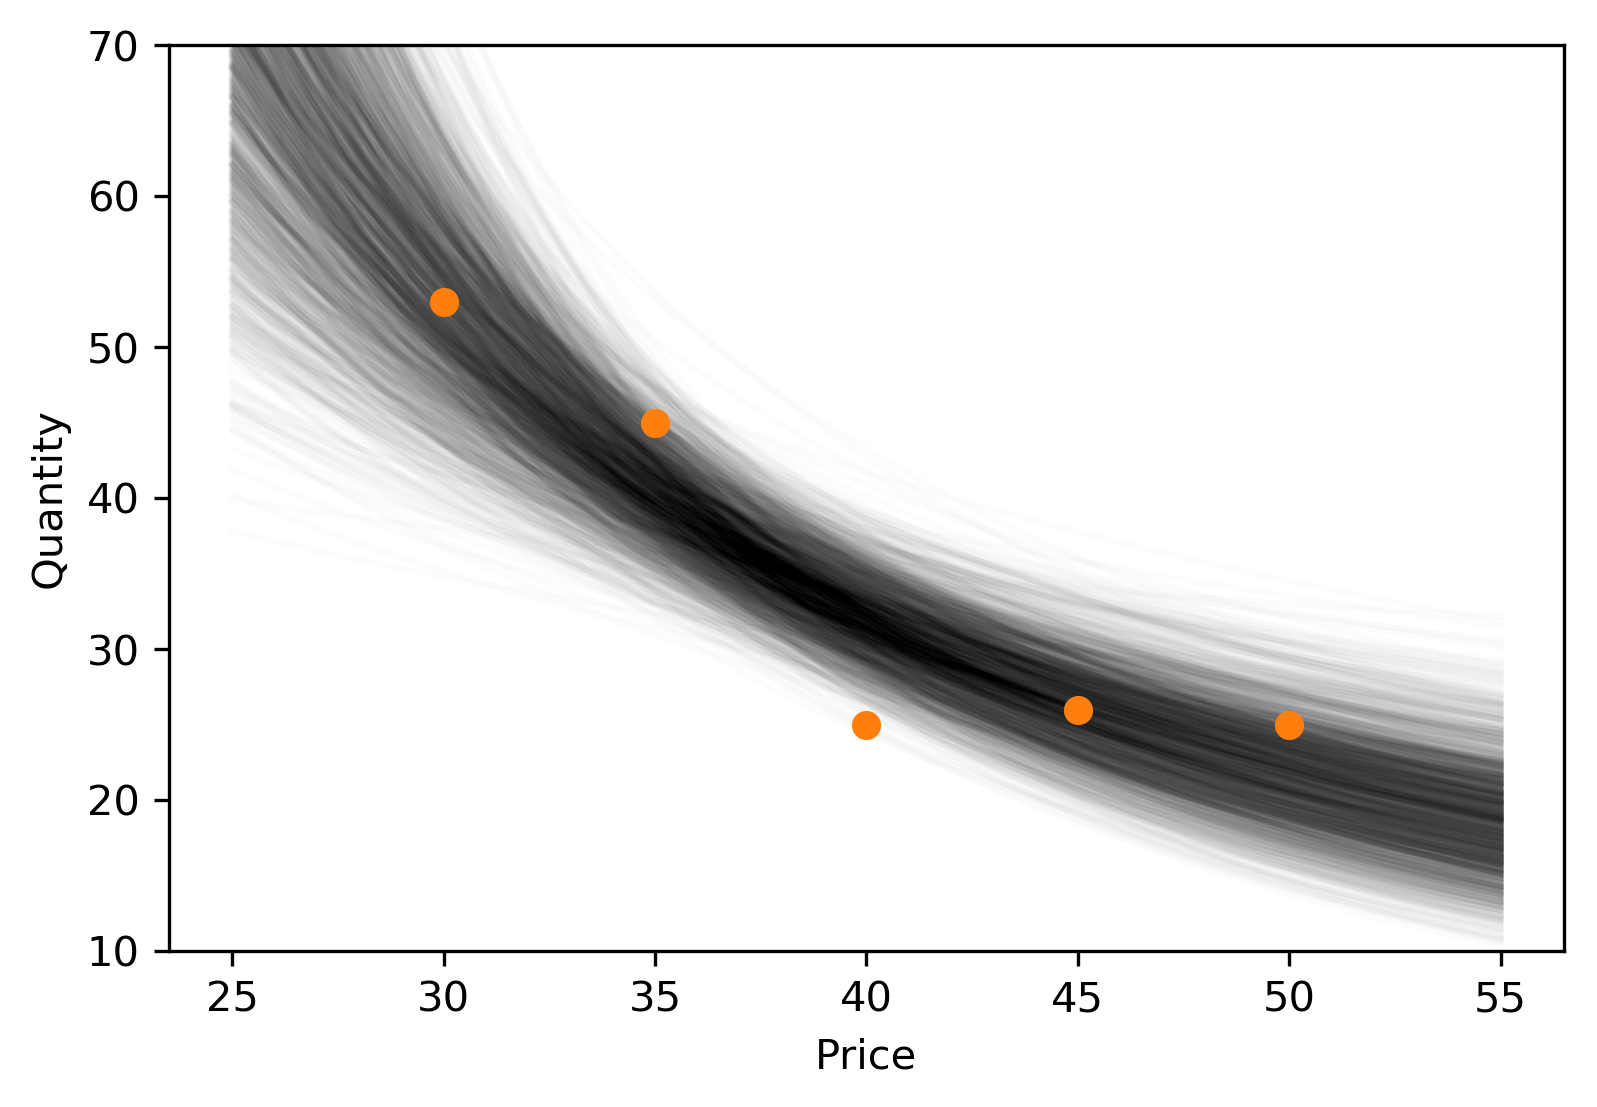

In [12]:
# Checking model fit

plt.plot(p,μ,c='k',alpha=0.01);
plt.plot(p0,q0,'o',c='C1');
#plt.plot(p,eq)
plt.ylim(10,70)
plt.xlabel('Price')
plt.ylabel('Quantity')
savefig("qhat")

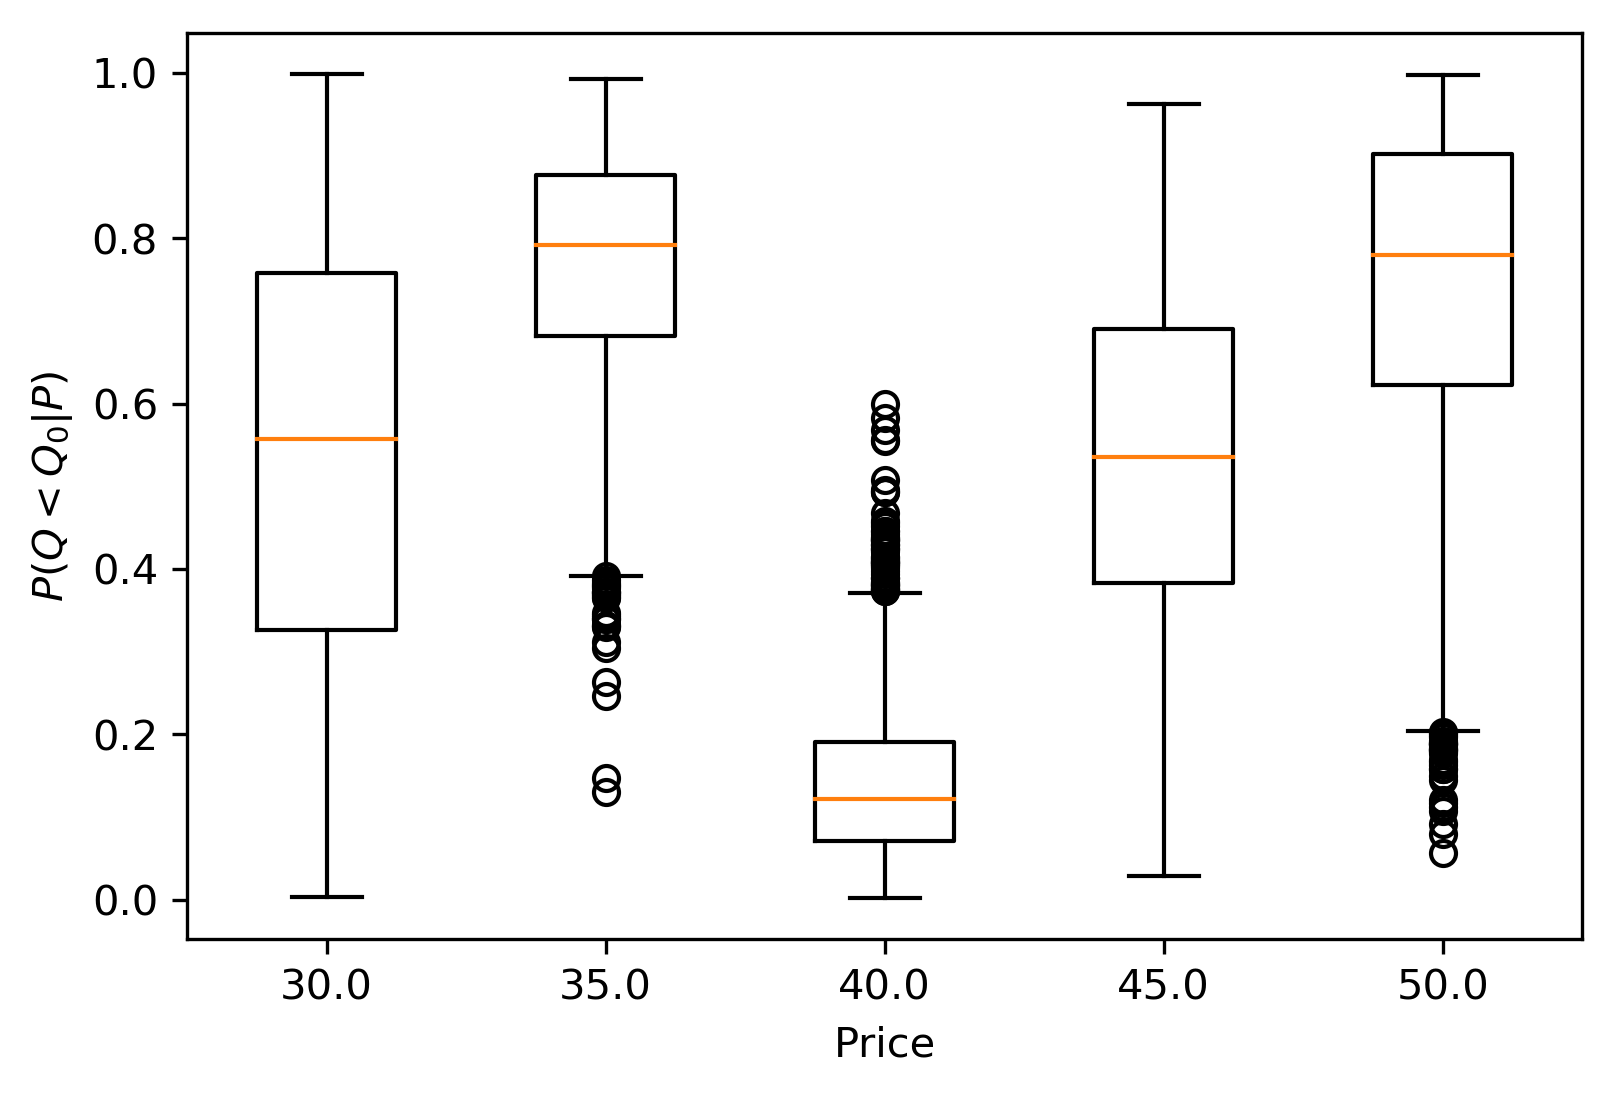

In [13]:
import scipy
plt.boxplot(scipy.stats.poisson.cdf(q0,mu=t['μ0']));
plt.xticks(range(1,6),p0);
plt.xlabel('Price')
plt.ylabel('$P(Q<Q_0 | P)$');
savefig("q0ppc")

In [14]:
import scipy
np.mean(q0  > np.random.poisson(t['μ0']), 0)

array([0.494 , 0.729 , 0.1095, 0.451 , 0.6725])

In [15]:
p = np.linspace(25,55)
μ,π = predict(t,p)

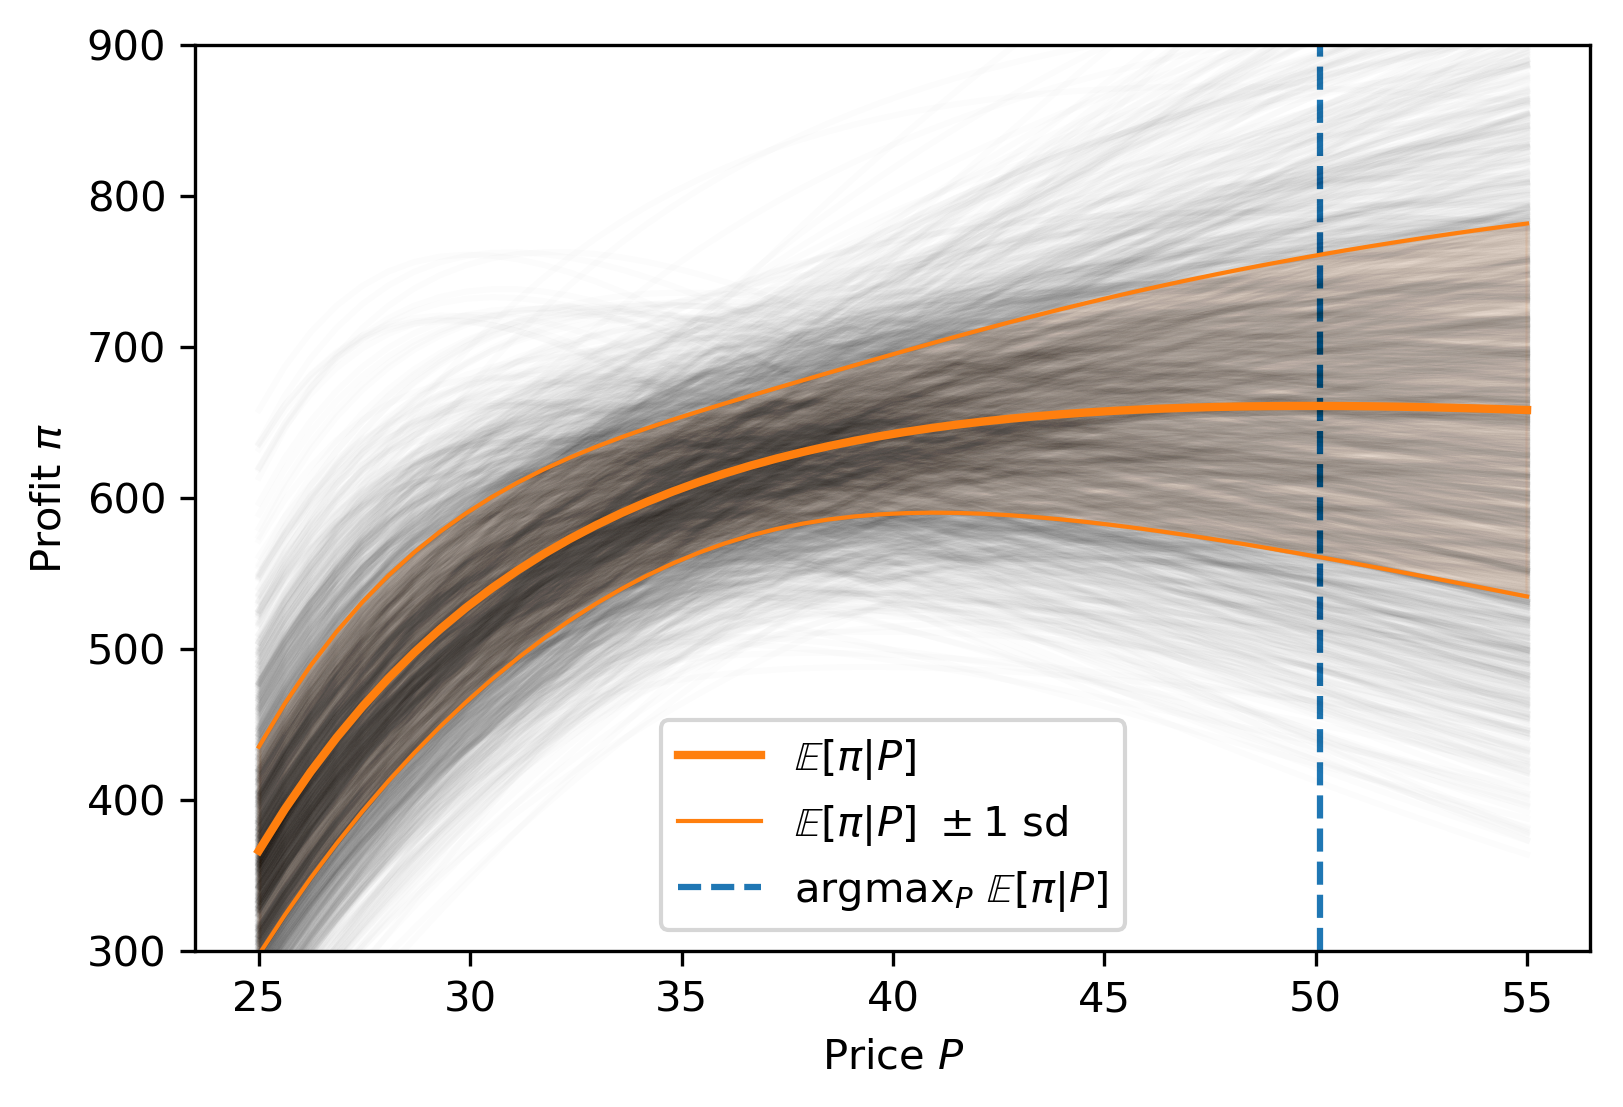

In [16]:
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(p,np.mean(π,1).T,c='C1',lw=2,label="$\mathbb{E}[\pi|P]$");
plt.fill_between(p,(np.mean(π,1)-np.std(π,1)).T,(np.mean(π,1)+np.std(π,1)).T,alpha=0.1,color='C1')
plt.plot(p,(np.mean(π,1)+np.std(π,1)).T,c='C1',lw=1,label="$\mathbb{E}[\pi|P]\ \pm$1 sd");
plt.plot(p,(np.mean(π,1)-np.std(π,1)).T,c='C1',lw=1);
pmax = p[np.argmax(np.mean(π,1))]
plt.vlines(pmax,300,900,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[\pi|P]$")
#plt.plot(p,(p - k) * eq)
plt.ylim(300,900);
plt.xlabel("Price $P$")
plt.ylabel("Profit $\pi$")

plt.legend();
savefig("max_of_means")

# Bootstrap

In [17]:
pboot = boot(t,np.linspace(40,60,1000),10000)

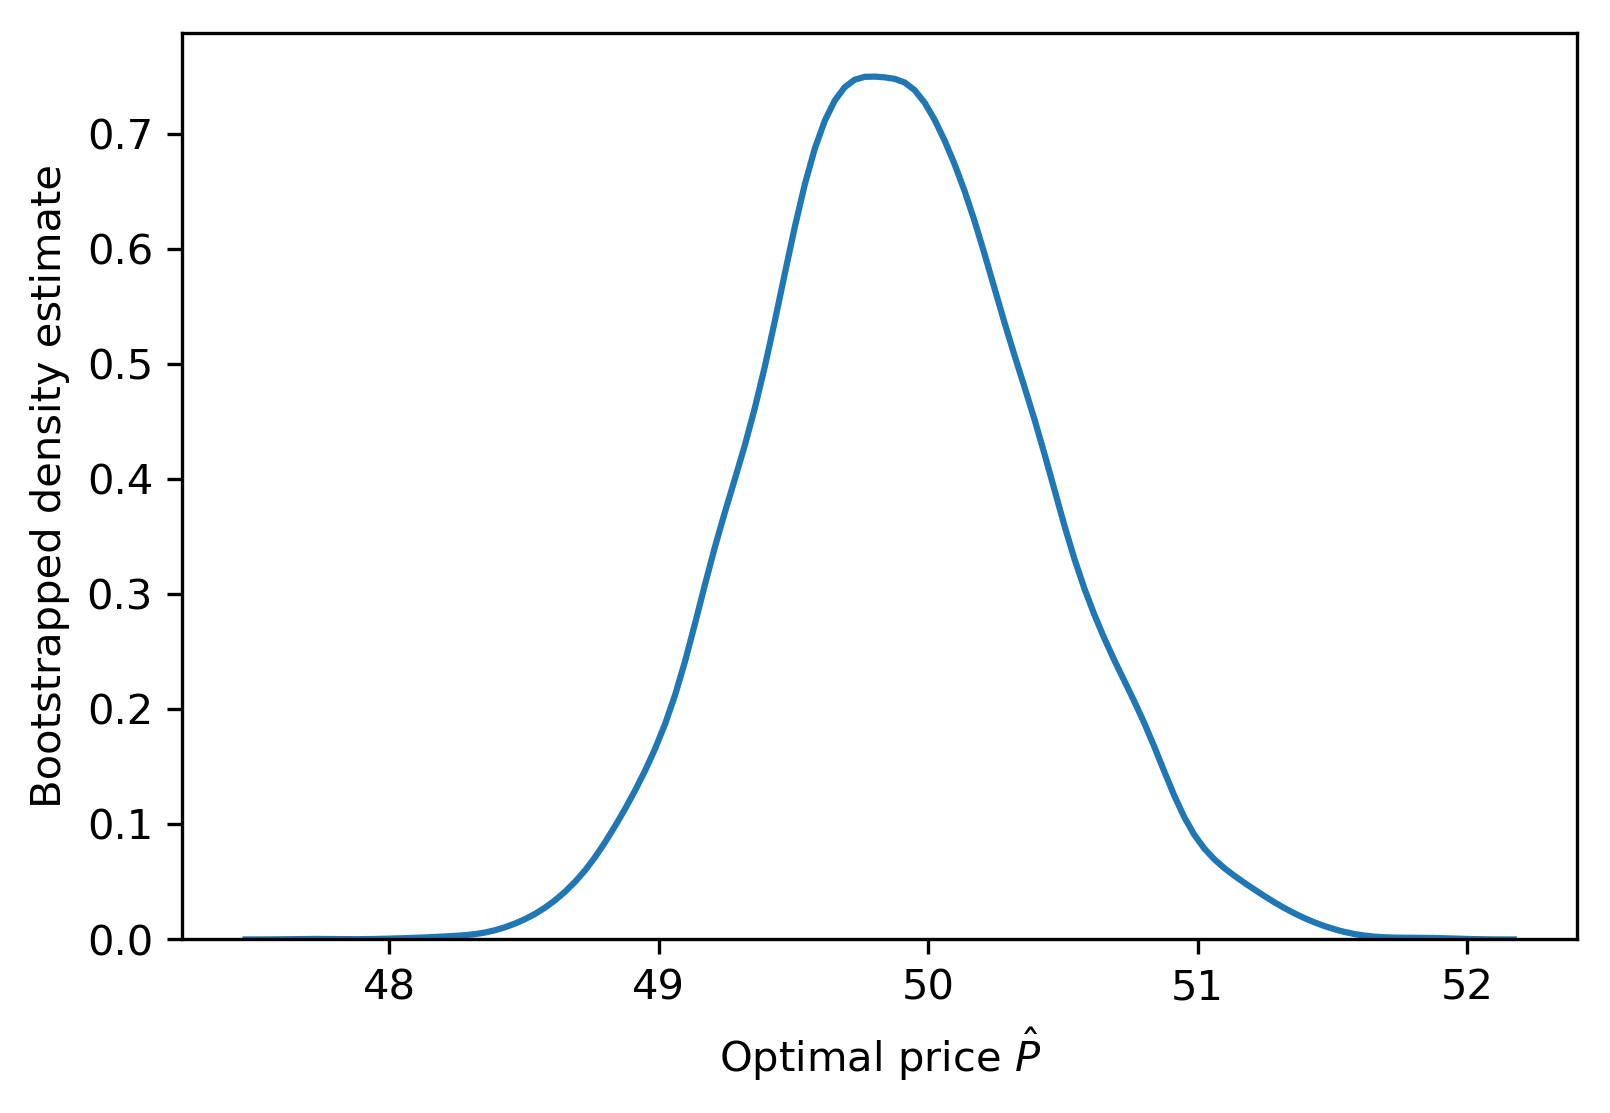

In [18]:
import seaborn as sns
sns.kdeplot(pboot);
plt.xlabel('Optimal price $\hat{P}$')
plt.ylabel('Bootstrapped density estimate');
savefig("boot1")

# Sensitivity Analysis

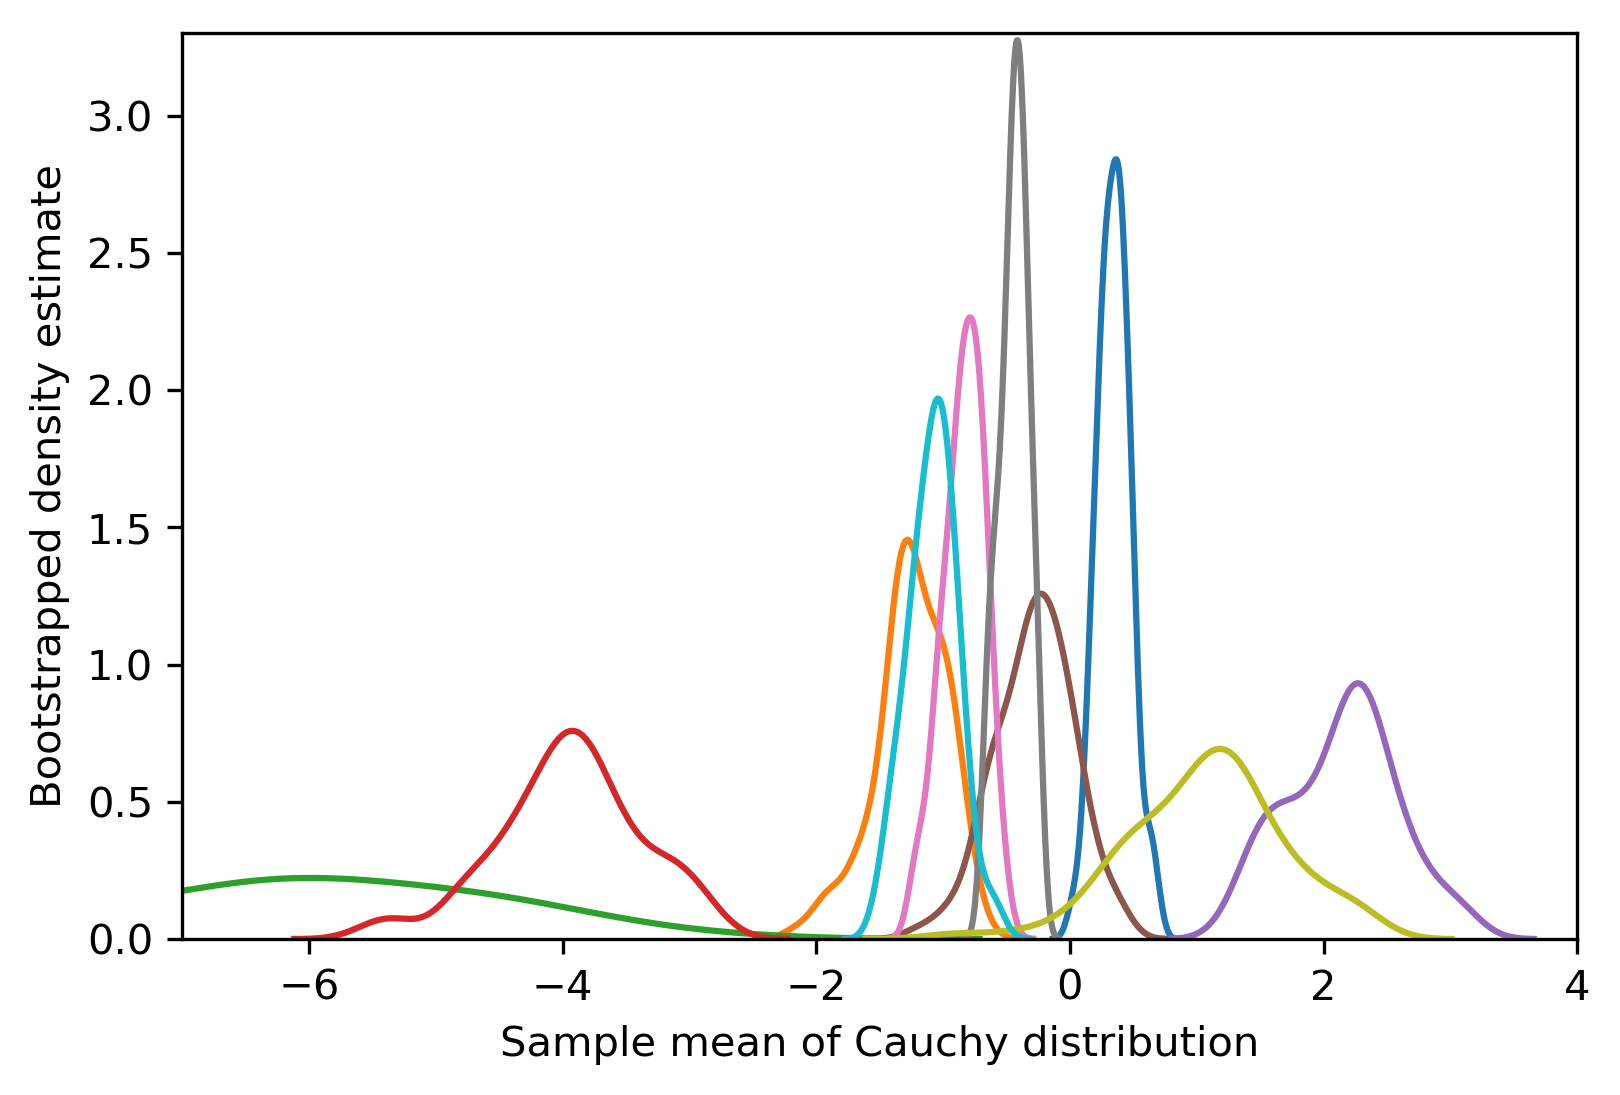

In [19]:

n = 100
k = 2000

np.random.seed(1)
ymax = 0
for j in range(10):
    x = np.random.standard_cauchy(size=n)
    m = np.sort(np.mean(resample(x,n_samples=n*k).reshape(n,k),1))
    sns.kdeplot(m)
plt.xlim(-7,4)
plt.ylim(0,3.3)
plt.xlabel('Sample mean of Cauchy distribution')
plt.ylabel('Bootstrapped density estimate')
savefig('cauchy-bootstrap')

In [20]:
a,b = np.mean(t.α),np.mean(t.β)
a,b

(3.494043507665335, -1.725606291962481)

In [21]:
rep = fitrep(p0,np.exp(a + b * (np.log(p0) - logp0mean)),800)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:11<00:00, 352.50draws/s]


# now

In [22]:
out1 = withrep(rep,np.logspace(np.log10(20),np.log10(300),1000),max_of_means)

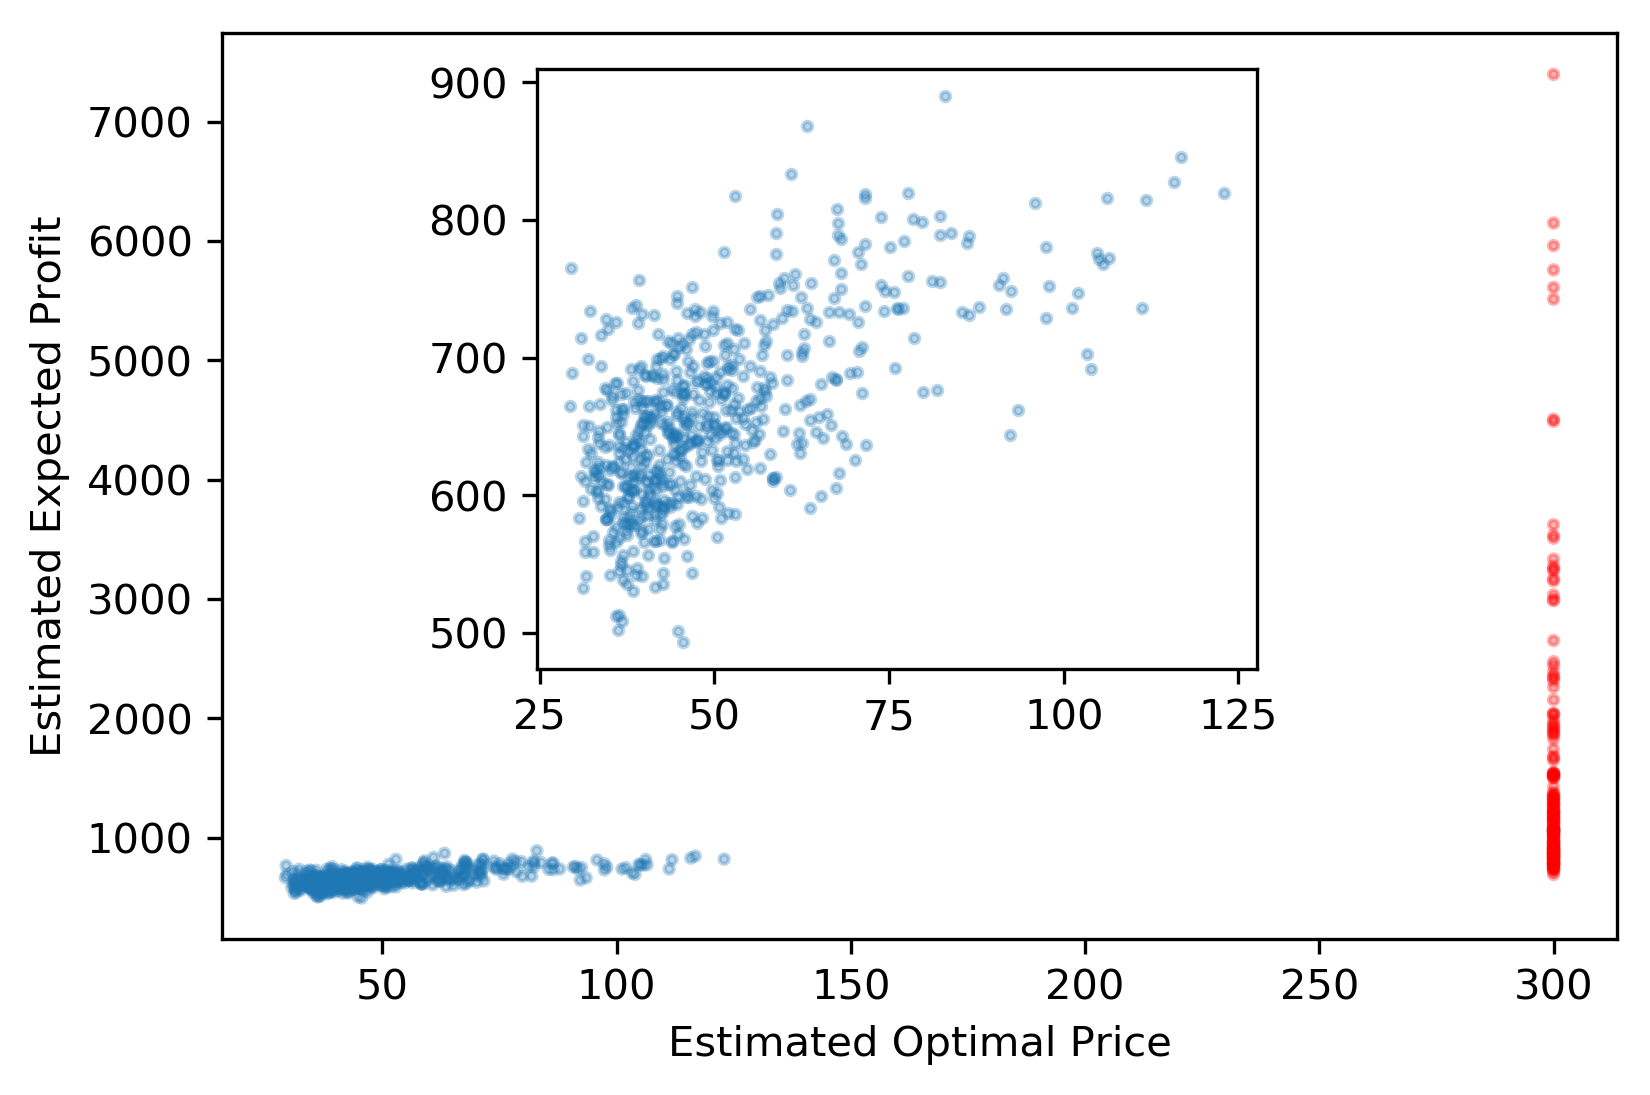

In [23]:
c = np.where(out1[:,0]>300,'red','C0')
ax1 = plt.axes()
ax2 =  plt.axes([0.3,0.35,0.4,0.5])
ax1.scatter(*out1.T,alpha=0.3,s=5,c=c)
#plt.xscale('log')
#plt.yscale('log')
mask = out1[:,0]<200
ax2.scatter(*out1[mask,:].T,alpha=0.3,s=5,c='C0')


ax1.set_xlabel('Estimated Optimal Price')
ax1.set_ylabel('Estimated Expected Profit');
savefig('replications')

In [24]:
scipy.stats.chi2(2).ppf(0.95)

5.991464547107979

(-4, 1)

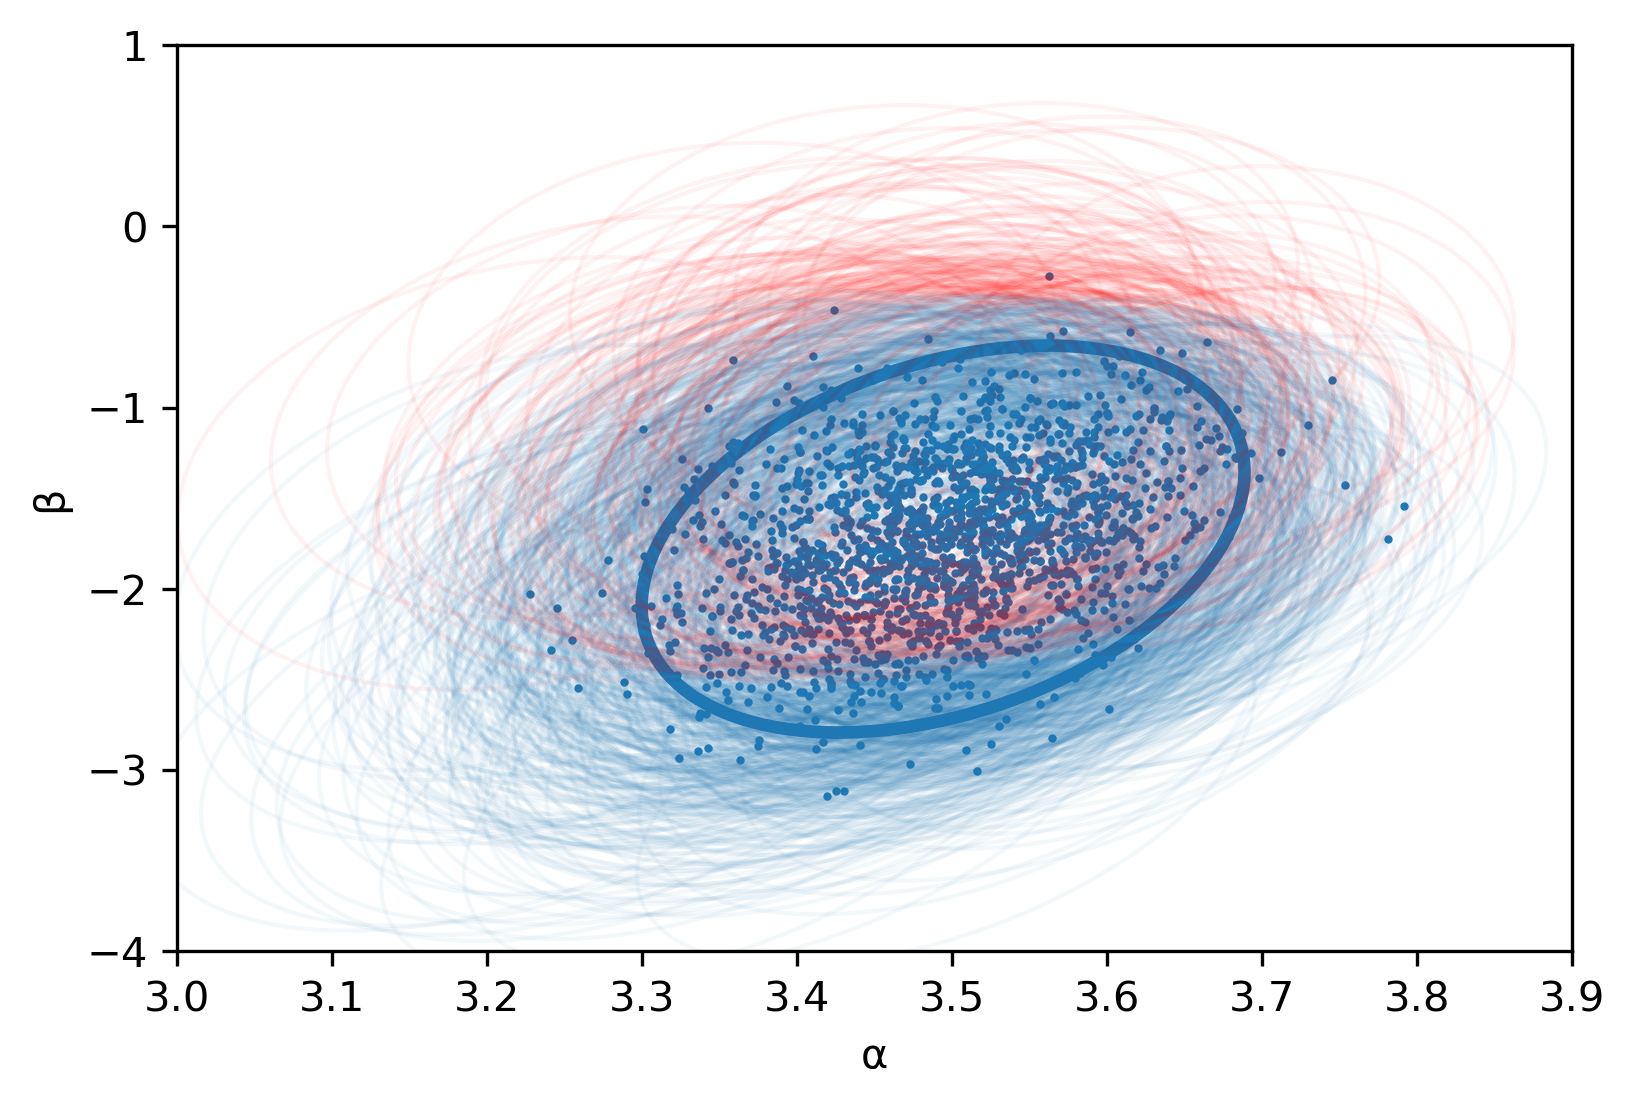

In [25]:
ax = plt.subplot(111)

plt.scatter(t.α,t.β,s=1,c='C0')
mean = (np.mean(t.α),np.mean(t.β))
cov = np.cov(t.α,t.β)
ellipse = normalEllipse(mean,cov,color='C0',lw=3)
ellipse.set_facecolor('none')
ax.add_artist(ellipse)
for j in range(rep.α.shape[1]):
    mean = (np.mean(rep.α[:,j]),np.mean(rep.β[:,j]))
    cov = np.cov(rep.α[:,j],rep.β[:,j])
    ellipse = normalEllipse(mean,cov,alpha=0.05,color=c[j])
    ellipse.set_facecolor('none')
    ax.add_artist(ellipse)
plt.plot(rep.α,rep.β,'.',color='none');
plt.xlabel('α')
plt.ylabel('β');
plt.xlim(3,3.9)
plt.ylim(-4,1)
#savefig("ellipses")

In [26]:
popt = 20*b/(1+b)
popt 

47.56315679940953

In [27]:
np.mean(resample(x))

-2.8482918422451586

In [28]:
out2 = withrep(rep,np.logspace(np.log10(20),2.5,1000),median_of_maxes)

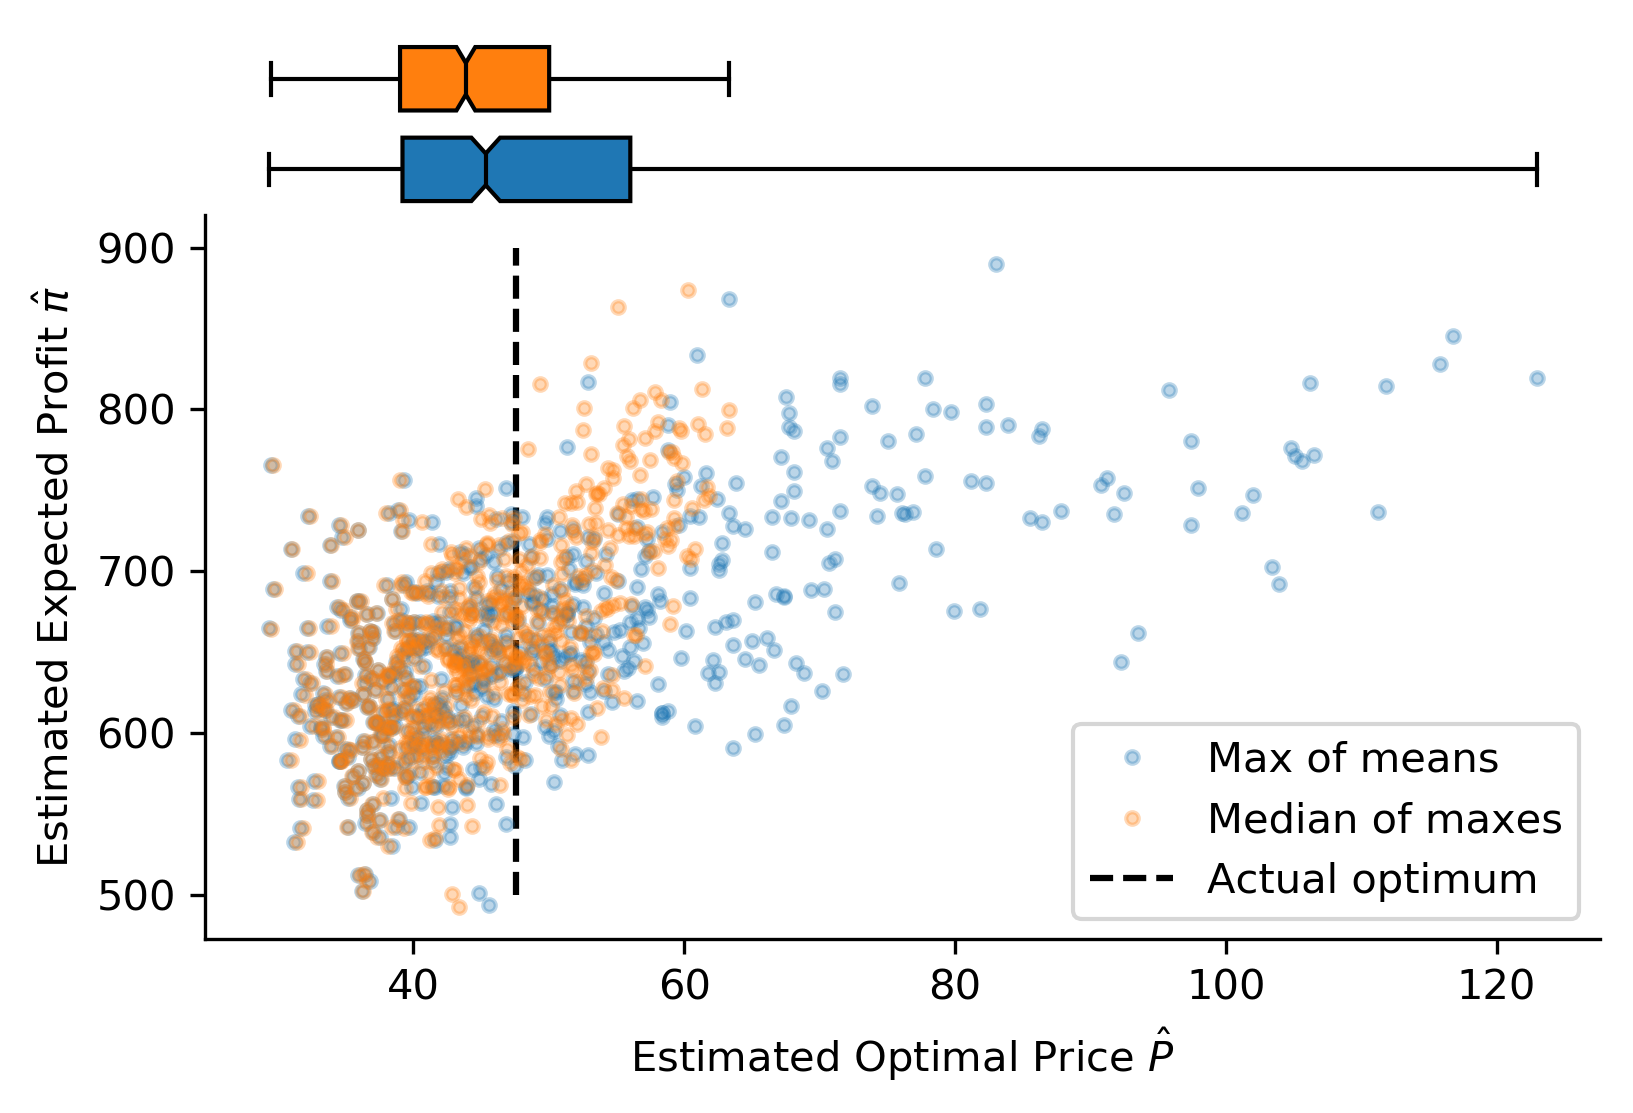

In [29]:
#from matplotlib import gridspec
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[1, 4]})
# for item in [fig, ax2, ax1]:
#    item.patch.set_visible(False)


#gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

ax1.set_frame_on(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

s = out1[:,0]<200

colors = ['C0', 'C1']

ax2.plot(*out1[s,:].T,'.',alpha=0.3,
         label="Max of means",
         color=colors[0]
        )
ax2.plot(*out2[s,:].T,'.',alpha=0.3, 
         color=colors[1],
         label='Median of maxes')

ax2.vlines(popt,500,900,label="Actual optimum",linestyles='dashed')
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)


#sns.kdeplot(out1[s,0],shade=True,ax=ax1)
#sns.kdeplot(out2[s,0],shade=True,ax=ax1)
bplot = ax1.boxplot(np.vstack([out1[s,0],out2[s,0]]).T,
                    vert=False,patch_artist=True,notch=True,
                    showfliers=False,widths=0.7,whis=100
                   );
bplot['medians'][0].set_color('k')
bplot['medians'][1].set_color('k')

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_yticks([])
#ax1.vlines(popt,0,0.045,label="Actual optimum",linestyles='dashed')
#ax1.set_ylim(0,0.045)

plt.xlabel('Estimated Optimal Price $\hat{P}$');
ax2.set_ylabel('Estimated Expected Profit $\hat{\pi}$');
ax2.legend();
savefig('opt-compare')

# Per-estimate optimization

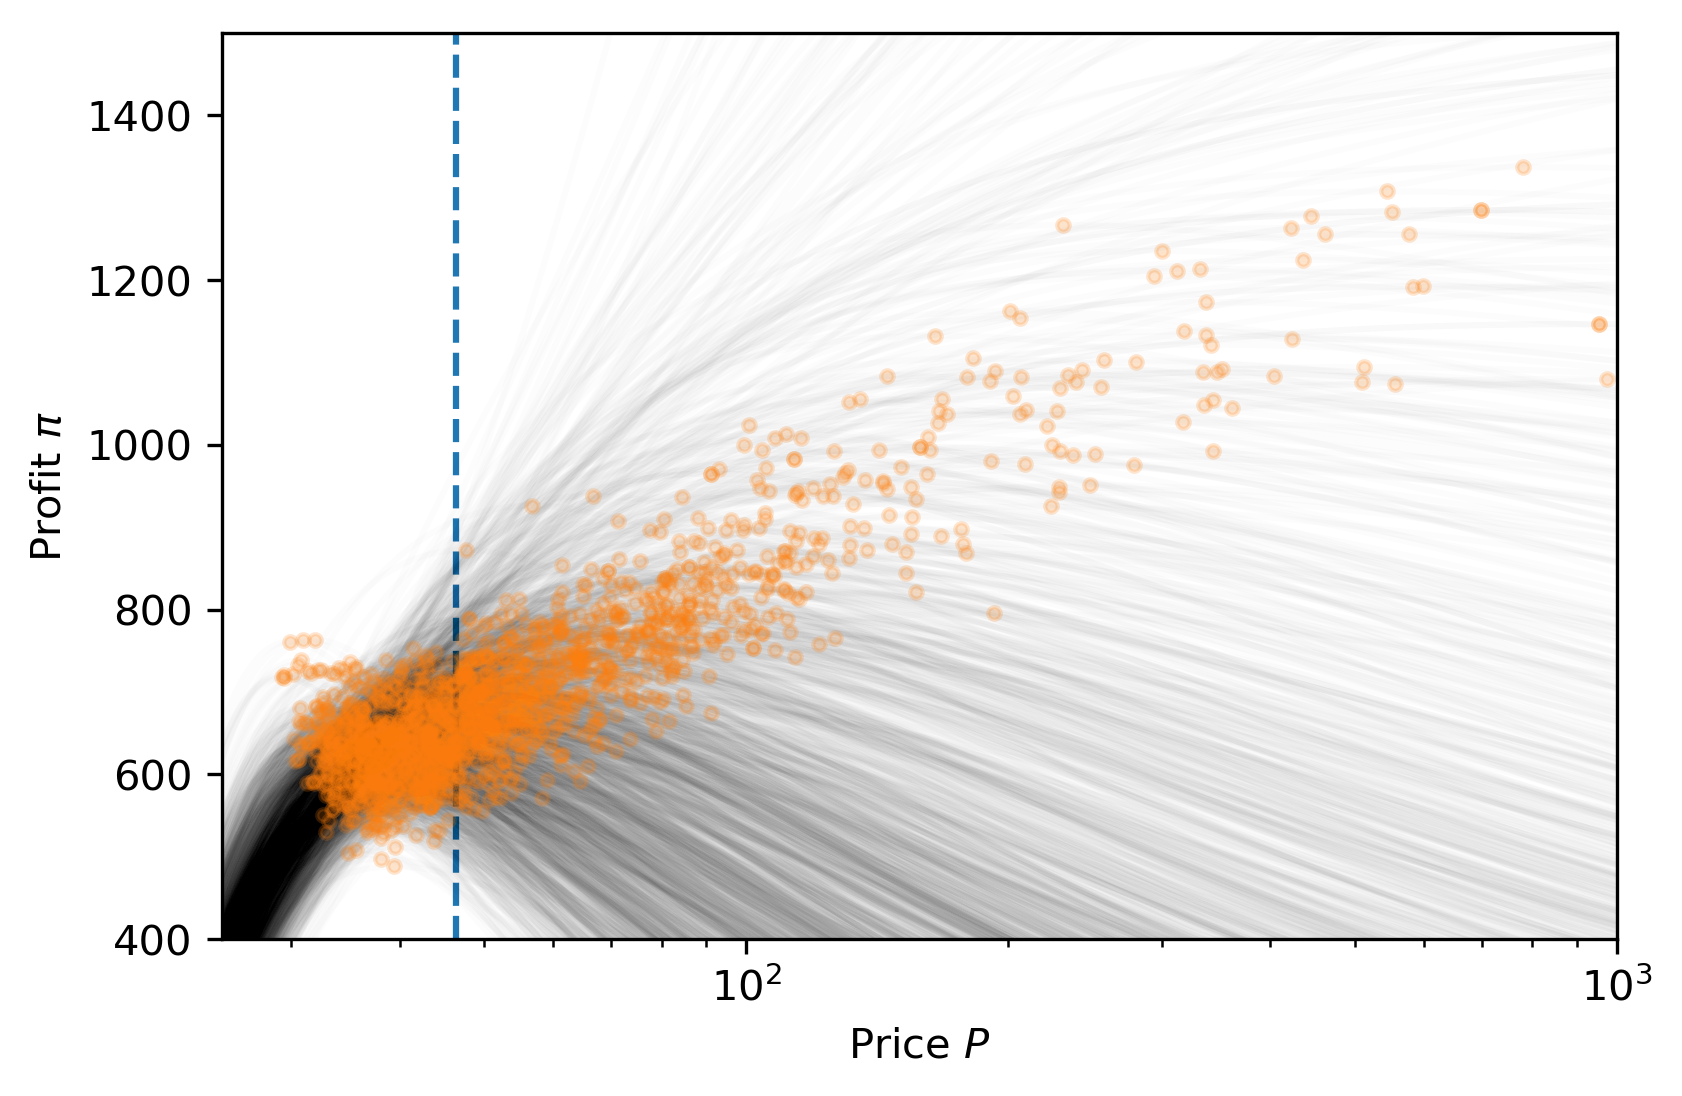

In [30]:
p = np.logspace(np.log10(25),3,1000)
μ,π = predict(t,p)

plt.plot(p,π,c='k',alpha=0.01);
# plt.plot(p,np.mean(π,1).T,c='C1',lw=2,label="$\mathbb{E}[\pi|P]$");
pmax = p[np.argmax(np.mean(π,1))]
#plt.plot(p,(p - k) * eq)

plt.xlabel("Price $P$")
plt.ylabel("Profit $\pi$")



phat = 20*t.β/(1+t.β)
πhat = (phat-20)*(np.exp(t.α + t.β * (np.log(phat) - np.log(p0).mean())))
# plt.hist(phat[s],bins=100);
plt.plot(phat,πhat,'.',alpha=0.2,c='C1')
plt.vlines(np.median(phat),400,1500,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[\pi|P]$")

# plt.xlim(20,1000)
# plt.xscale('log')
# plt.xlabel('Optimal Price $\hat{P}$')
# plt.ylabel('Expected Profit at Optimal Price');
plt.xlim(25,1000)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(400,1500);

In [31]:
np.mean(t.β<-1)

0.9575

In [32]:
np.mean(phat>0)

0.9575

In [33]:
p_ppc = np.zeros(rep.β.shape[1])
π_ppc = np.zeros(rep.β.shape[1])

# Is this right? Indices seem like they could be way off
p = np.logspace(np.log10(20),2.5,1000)
for i in range(rep.β.shape[1]):
    d = {'α':rep.α[:,i],'β':rep.β[:,i]}
    μ,π = predict(d,p)
    πmean = np.mean(π,1)
    jmax = np.argmax(πmean)
    p_ppc[i] = p[jmax]
    π_ppc[i] = πmean[jmax]